# Varietal by Sets of Reviewers


In this notebook we'll explore wine varietals based on the sets of tasters that have reviewed them. To do this, for each varietal, we'll take the set of reviewers that reviewed that varietal, and embed the sets into a 2d representation. We'll then be able to compare them. 

This is an example of embedding **variable width categorical data** where **counts don't matter**.

In [ ]:
#Quick cell to make jupyter notebook use the full screen width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [ ]:
#Some plotting libraries
import matplotlib.pyplot as plt
%matplotlib inline

from bokeh.plotting import show, save, output_notebook, output_file
from bokeh.resources import INLINE 
output_notebook(resources=INLINE)

In [ ]:
from src import workflow
from src.data import Dataset
from src import paths
import pprint

In [ ]:
import umap
import umap.plot
from vectorizers import NgramVectorizer
import numpy as np

## Get Data

In [ ]:
ds = Dataset.load('wine_reviews_130k')

In [ ]:
print(ds)

In [ ]:
print(ds.DESCR)

In [ ]:
df = ds.data

In [ ]:
df.head()

In [ ]:
df.shape

## Getting the Data in the Right Format

First of all, we need a dataframe that one row per variety instead of one row per review.

This is a job for groupby.  We groupby the column we'd like to embed and then use agg with a dictionary of column names to aggregation functions to tell it how to summarize the many reviews about a single beer into one record.  Aggregation functions are pretty much any function that takes an iterable and returns a single value.  Median and max are great functions for dealing with numeric fields.

Note that we'll want to drop out entries that don't have a recorded taster as well (this is most of the reviews!)

In [ ]:
df.taster_name.value_counts(dropna=False)

In [ ]:
df_taster = df.dropna(axis=0, subset=['taster_name'])

In [ ]:
varietal = df_taster.groupby('variety').agg({
    'variety':'count',
    'price':'mean',
    'points':'mean',
    'taster_name': [lambda x: list(x.unique()), lambda x: len(x.unique())],
}).reset_index()
varietal.columns = """variety num_reviews price points
taster_name_list num_tasters""".split()

In [ ]:
varietal.sort_values('num_tasters', ascending=False)

## First step of the embedding: Vectorization

We are going to vectorize our `taster_name_list` data. This step turns the list of tasters into a sparse matrix of counts. One row per row of our data frame and one column per unique token that appeared in our categorical field of interest (in this case, taster_name).

When we did our groupby, we made each taster appear once, so we will be necessarily treating this as a case where "counts don't matter". That is, the `taster_name_list` is effectively as `taster_name_set` as a tester is either in it or not. We'll use `NgramVectorizer` to turn the `taster_name_list` into a vector that counts the number of times each taster appears in a list (in this case, 1 or 0 since our tasters are unique in each `taster_name_list`.


We use `min_document_occurrences=10` in our `NgramVectorizer` to only count tasters who have reviewed at least 10 wines. Here a *document* corresponds to a *varietal*. 

In [ ]:
wine_by_tasters_vectorizer = NgramVectorizer(min_document_occurrences=10)
variety_by_taster = wine_by_tasters_vectorizer.fit_transform(varietal.taster_name_list)

In [ ]:
variety_by_taster.shape

## Next step: Dimension Reduction
Now that we have a numerical representation, we can reduce dimension to get our desired low-dimensional embedding. We'll make ours 2d for easy visualization.

Since we're in a **counts don't matter** situation, or if you prefer, we're considering our **tasters** as a set, we'll use `jaccard` for our metric.

In [ ]:
%%time
variety_by_tasters_model = umap.UMAP(n_neighbors=5, n_components=2, metric='jaccard', min_dist=0.1,
                                  unique=True, random_state=42).fit(variety_by_taster)

In [ ]:
umap_plot = umap.plot.points(variety_by_tasters_model, labels=varietal.num_tasters, theme='fire');#, show_legend=False);

In [ ]:
path_to_figures = paths['project_path'] / 'reports' / 'figures'
root_filename = 'varietal_by_taster_jaccard'
outfile_png = path_to_figures / (root_filename + '.png')
outfile_html = path_to_figures / (root_filename + '.html')

In [ ]:
umap_plot = umap.plot.points(variety_by_tasters_model, labels=varietal.num_reviews, theme='fire', show_legend=False);
#umap_plot.figure.savefig(outfile_png, dpi=300, bbox_inches='tight')

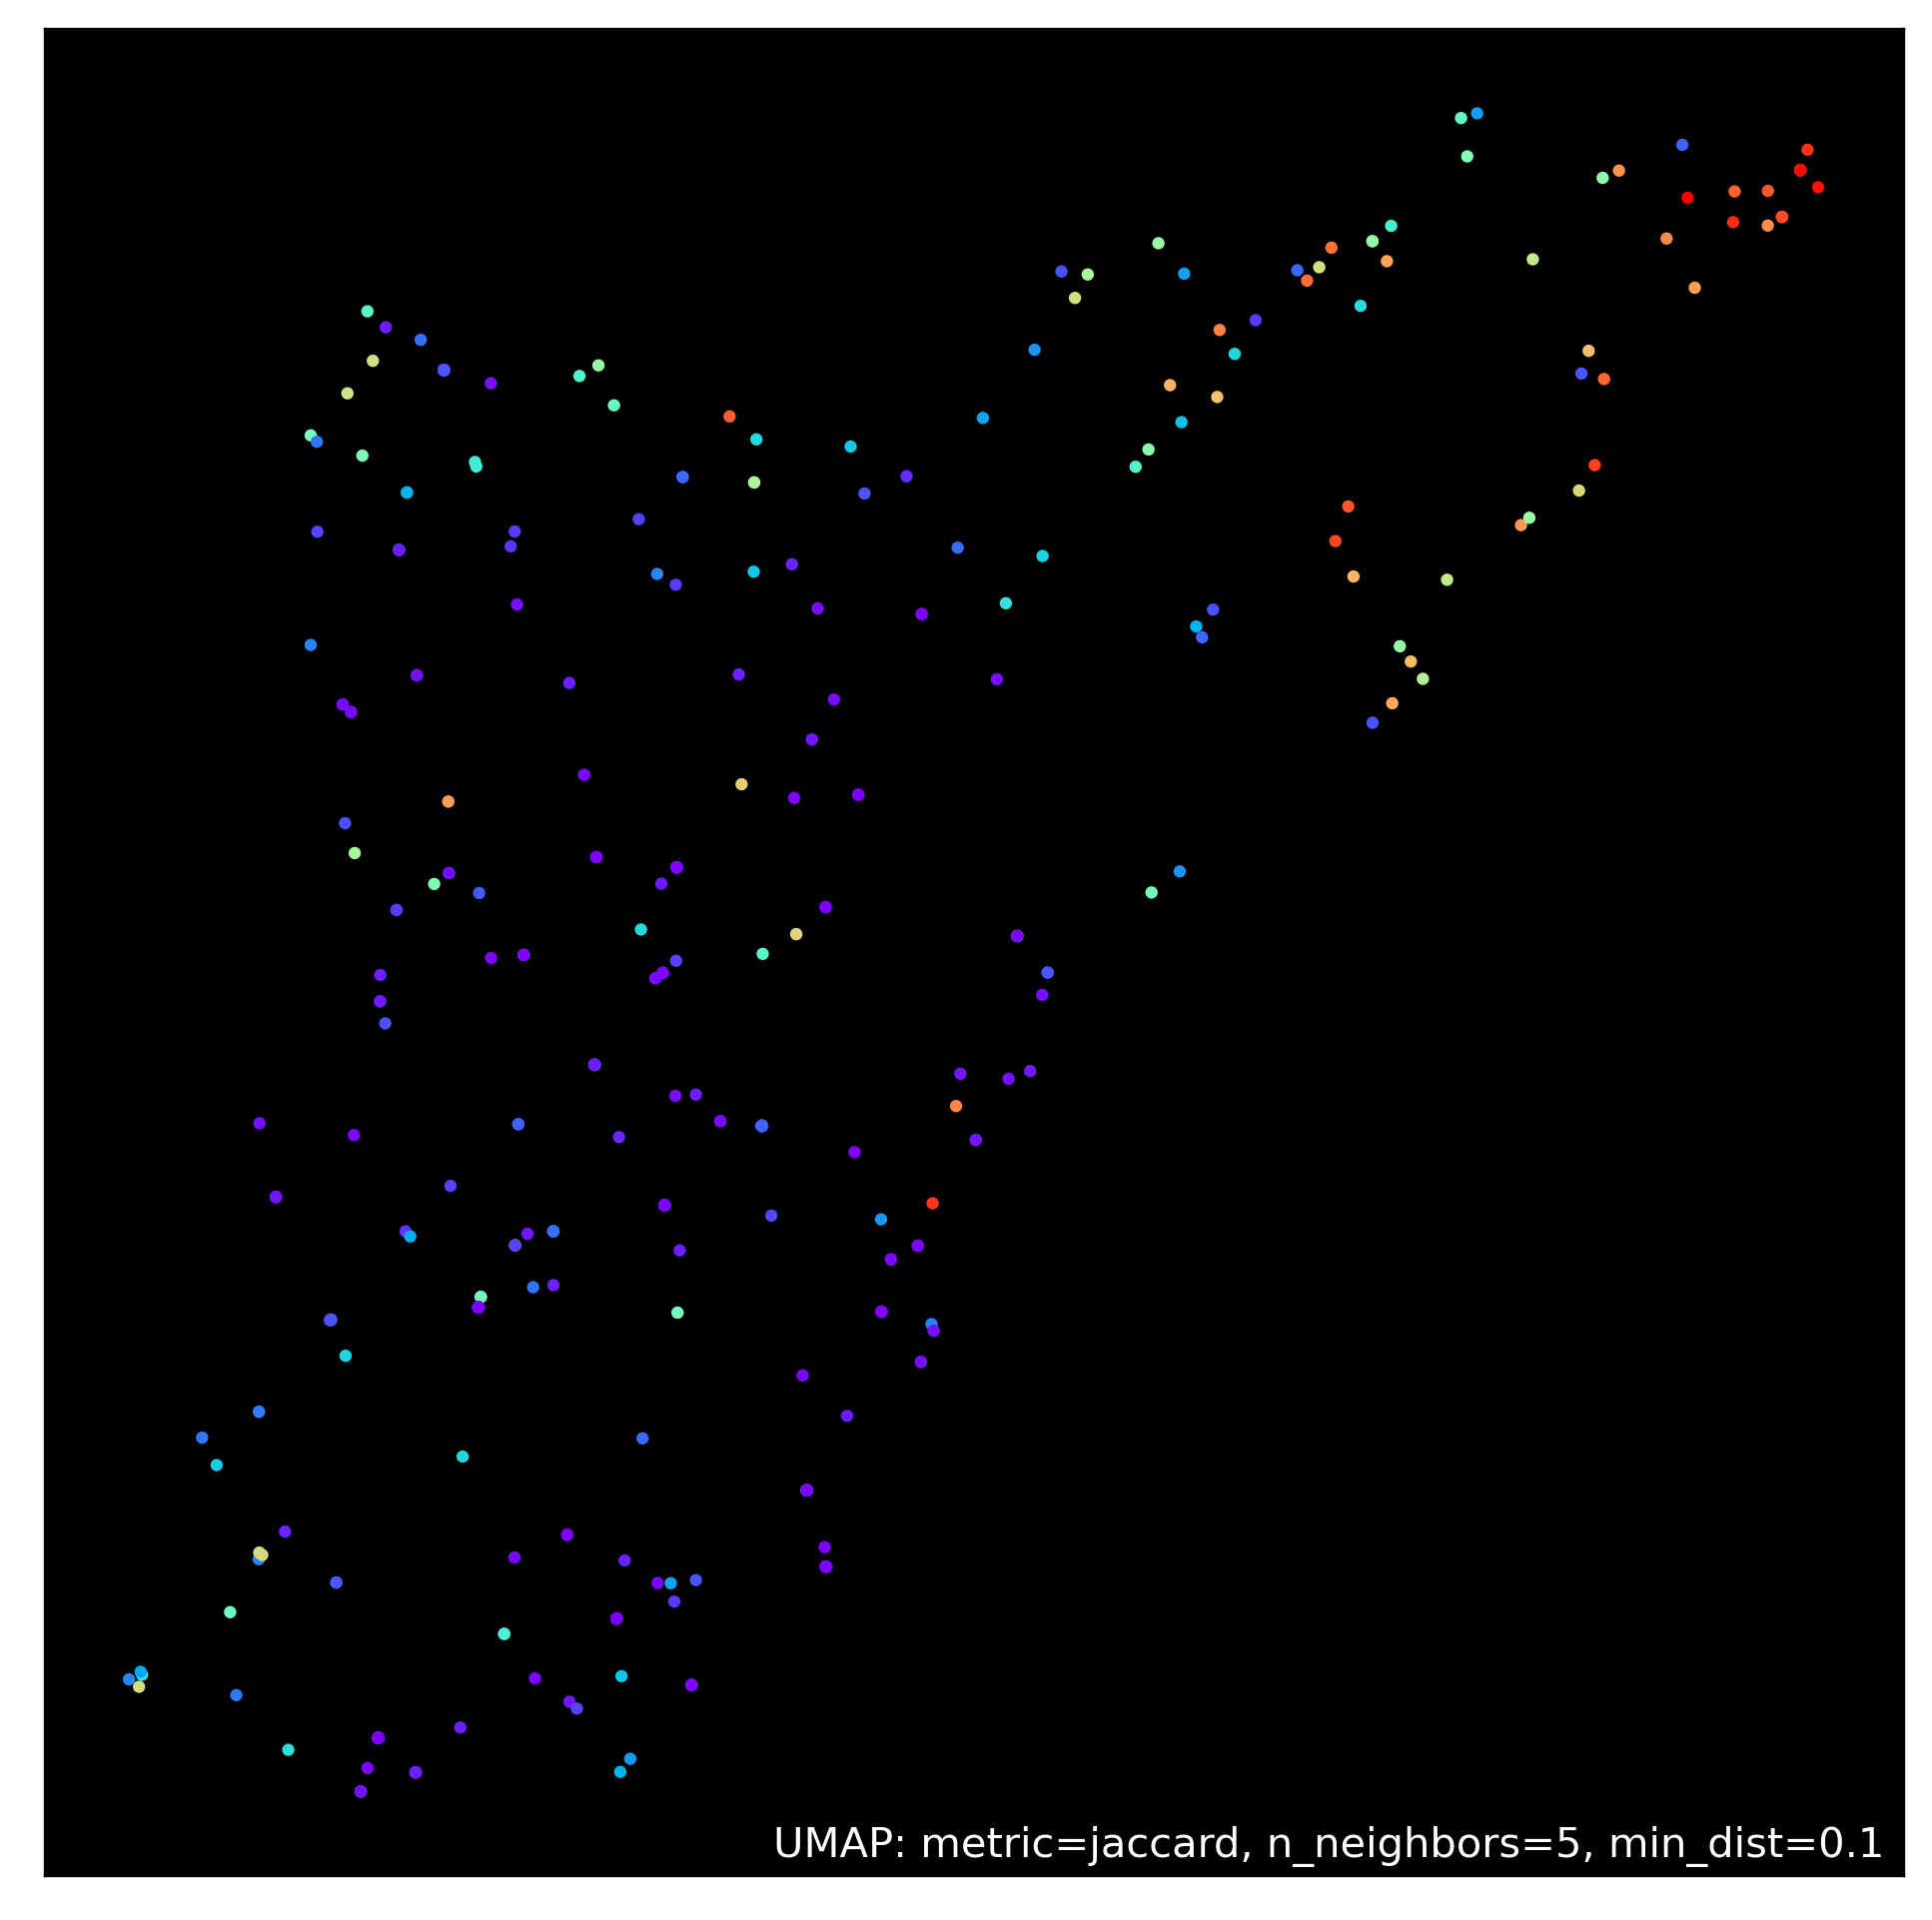

It looks like the more common varietals were reviewed by all of the reviewers, while less commonly reviewed varietals were reviewed by smaller subsets of reviewers.

And now for an interactive plot...

In [ ]:
hover_df = varietal
f = umap.plot.interactive(variety_by_tasters_model, labels=varietal.num_reviews, 
                          hover_data=hover_df, theme='fire', point_size=5);
#save(f, filename=outfile_html)
show(f)